# TP 04 : Régression logistique Multinomiale

Nous avons implémenté le cas d'une seule classe (binaire : oui ou non). Pour appliquer un classement sur plusieurs classes, on peut entrainner $L$ modèles de régression logistique (où $L$ est le nombre des classes). Dans ce cas, nos résultats (Y) doivent encodée en 0 et 1. Pour un modèle $M_i$ d'une classe $C_i$, la sortie $Y$ doit avoir 1 si $C_i$, 0 si une autre classe. (One-to-rest classification)

Une autre approche (celle qu'on va implémenter) est d'encoder la sortie en utilisant OneHot encoder. Pour $L$ classes et un échantillon donnée, on va avoir $L$ sorties (une ayant 1 et les autres 0). Pour un dataset avec $M$ échantillons, $N$ caractéristiques et $L$ classes, on va avoir les dimensions suivantes : 
- $X (M, N)$
- $Y (M, L)$
- $\theta (L, N)$

Cette dernière approche s'appelle maximum entropy (MaxEnt). Elle généralise la régresion logistique.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

## 1- Implémentation 

### 1.1- Fonctions utiles

In [2]:
# Défininir des fonctions qui génèrent des vecteurs ou des matrices
# Ces fonctions seront utilisées pour générer les Thétas

def generer_zeros_2(nbr_x, nbr_y):
    return np.zeros((nbr_x, nbr_y))

def generer_uns_2(nbr_x, nbr_y):
    return np.ones((nbr_x, nbr_y))

def generer_aleatoire_2(nbr_x, nbr_y):
    return np.random.rand(nbr_x, nbr_y)
    
generer_zeros_2(2, 3), generer_uns_2(2, 3), generer_aleatoire_2(2, 3)

(array([[0., 0., 0.],
        [0., 0., 0.]]), array([[1., 1., 1.],
        [1., 1., 1.]]), array([[0.59442395, 0.99468059, 0.42110744],
        [0.10874125, 0.78075633, 0.71791204]]))

In [3]:
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

In [4]:
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = (X - mean)/std
    return X_norm, mean, std

### 1.2- Combinaison linéaire
On combine les m caractéristiques linéairement. La seule chose différente est que z dans ce cas est une matrice. (nombre_échantillons * nombre_classes) 

$$z=\theta_0+\sum\limits_{i=1}^{m} \theta_i x_i = X \theta^T $$

In [5]:
# TODO implémenter la fonction de combinaison linéaire 
def z_n(X, Theta): 
    return np.dot(X,Theta.T)

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

#Résulat : 
# array([[0. , 0. , 0. ],
#       [0.5, 0.1, 0.6],
#       [0.2, 0.3, 0. ],
#       [0.7, 0.4, 0.6]])
z_n(X_tn, Theta_tn)

array([[0. , 0. , 0. ],
       [0.5, 0.1, 0.6],
       [0.2, 0.3, 0. ],
       [0.7, 0.4, 0.6]])

### 1.2- Calcul des probabilités

Les valeurs combinées sont transformées à des probabilités en utilisant la fonction softmax. $L$ est le nombre de classes. $Z$ est un vecteur des comninations linéaires.

Dans la fonction softmax génère des poids où la somme des colonnes toujours donne 1.0 

$$softmax(Z)=\frac{e^Z}{\sum\limits_{k=1}^{L} e^{Z_k}}$$

In [6]:
# TODO compléter la fonction softmax
def softmax(X):
    return (np.exp(X.T) / np.sum(np.exp(X.T), axis=0)).T

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

# Résultat : 
# array([[0.33333333, 0.33333333, 0.33333333],
#       [0.36029662, 0.24151404, 0.39818934],
#       [0.34200877, 0.37797814, 0.28001309],
#       [0.37797814, 0.28001309, 0.34200877]])
softmax(z_n(X_tn, Theta_tn))

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

In [7]:
def h_n(X, Theta_n, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return softmax(z_n(X_pre, Theta_n))

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

# Résulat : 
# array([[0.33333333, 0.33333333, 0.33333333],
#       [0.36029662, 0.24151404, 0.39818934],
#       [0.34200877, 0.37797814, 0.28001309],
#       [0.37797814, 0.28001309, 0.34200877]])
h_n(X_tn, Theta_tn)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

### 1.3- La fonction du cout 

- L: nombre des classes 
- M: nombre des échantillons

$$ cout(h_\theta(x), y) = - \sum\limits_{c=1}^{L} y_c \log(h_{\theta,c}(x))$$

$$J(\theta) = \frac{1}{M} \sum\limits_{i=1}^{M} cout(h_\theta(x^{(i)}), y^{(i)})$$

In [8]:
# TODO compléter 
def J_n(H, Y): 
    m=Y.shape[0]
    cout=(1 / m) * (np.sum(-np.sum(Y* np.log(H))))
    return cout

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

# 1.1913194426181715
J_n(h_n(X_tn, Theta_tn), Y_tn)

1.1913194426181715

### 1.4- Les gradients

$$\frac{\partial J(\theta)}{\theta_j} = \frac{1}{M} \sum\limits_{i=1}^{M} (h_\theta(x^{(i)}) - y^{(i)}) x_{ij} $$

In [9]:
# TODO compléter
def gradient_n(X, H, Y):
    m=Y.shape[0]
    return  (1/m)* np.dot(X.T, (H - Y)).T

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

# Résultat :
# array([[-0.06543131, -0.07000327],
#       [-0.11961822,  0.16449781],
#       [ 0.18504953, -0.09449454]])
gradient_n(X_tn, h_n(X_tn, Theta_tn), Y_tn)

array([[-0.06543131, -0.07000327],
       [-0.11961822,  0.16449781],
       [ 0.18504953, -0.09449454]])

### 1.5- Entraînnement (algorithme du gradient)

Les coéfficients sont mis à jour itérativement en se basant sur le gradient et un pas d'apprentissage $\alpha$. Puisque cette fonction a été implémentée dans le TP précédent, elle est donnée ici, mais d'une façon plus parametrable.

$$\theta_j = \theta_j - \alpha \frac{\partial J(\theta)}{\theta_j} $$

Notre fonction d'entrainnement prend les paramètres suivantes : 
- X : matrice (échantillons X caractéristiques)
- Y : vecteur (ou matrice) des résultas (échantillons X nombre_classes)
- norm : si on normalise X ou nom (par défaut : True)
- const : si on ajoute $\theta_0$ ou non (par défaut : True)
- nbr_iter : nombre des itérations avant de sortir
- alpha : le pas d'apparentissage (Learning rate)
- eps : le test d'arrêt si la différence entre les couts (actuel et précédent) est inférieur à $\epsilon$ on arrête la désente même si on n'a pas terminé toutes les itérations
- theta_func : la fonction qui génère les $\theta$ (par défaut : zéros)
- h_func : la fonction qui calcule les probabilités (par défaut : h_1)
- J_func : la fonction du cout (par défaut : J_1)
- grad_func : la fonction qui calcule le gradient (par défaut : gradient_1)

In [10]:
def entrainer_n(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_2, h_func=h_n, J_func=J_n, grad_func=gradient_n):
    
    X_pre, mean, std = preparer(X, norm=norm, const=const)
    
    Theta = theta_func(Y.shape[1], X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

theta_n, mean_n, std_n, couts_n = entrainer_n(X_tn, Y_tn, const=False)

# Résultat : 
# (array([[ 5.55111512e-17, -2.77555756e-17],
#        [ 2.32810552e+00, -2.32810552e+00],
#        [-2.32810552e+00,  2.32810552e+00]]),
# array([0.5, 0.5]),
# array([0.5, 0.5]),
# 0.5541027976268512)
theta_n, mean_n, std_n, couts_n[-1]

(array([[ 1.38777878e-17, -2.77555756e-17],
        [ 2.32810552e+00, -2.32810552e+00],
        [-2.32810552e+00,  2.32810552e+00]]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 0.5541027976268512)

### 1.6- Prédiction 

Etant donnée un seuil et des probabilités, pour chaque probabilité on rend 1 si elle dépasse ou égale le seuil, 0 sinon. 

In [41]:
# TODO compléter cette fonction 
# Elle doit calculer la 
# H est un vecteur de probabilités 
def predire_n(H, seuil=0.33): 
    return (H>=seuil)+0

# Résultat : 
# array([[1, 1, 1], # dans cette ligne, il faut mieux rendre un seul 1 et les autres 0
#       [0, 0, 1],
#       [0, 1, 0],
#       [1, 0, 0]])
predire_n(h_n(X_tn, Theta_tn))

array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 0],
       [1, 0, 1]])

### 1.7- Regrouper les fonctions ensemble 

Pour bien gérer l'entrainnement et la prédiction, on rassemble les fonctions que vous avez implémenté dans une seul classe. L'intérêt : 
- Si on applique la normalisation durant l'entrainnement, on doit l'appliquer aussi durant la prédiction. En plus, on doit utiliser les mêmes paramètres (moyenne et écart-type)
- On utilise les thétas optimales lors de la prédicition


In [12]:
class MaxEnt(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_2, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        #encoder = OneHotEncoder(sparse=False)
        #self.yencoder = encoder.fit(Y)
        # Y = self.yencoder.transform(Y)
        self.Theta, self.mean, self.std, self.couts = entrainer_n(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_n(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_n(H, seuil=seuil)

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])
Theta_tn = np.array([[0.5, 0.2], [0.1, 0.3], [0.6, 0.]])

# Résultat: 
# array([[9.41211100e-03, 9.90498451e-01, 8.94376295e-05],
#       [9.41211100e-03, 8.94376295e-05, 9.90498451e-01]])
maxent = MaxEnt(const=False)
maxent.entrainer(X_tn, Y_tn)
maxent.predire(np.array([[2., -2.],[-1., 1.]]))

array([[1.80328326e-02, 9.81635901e-01, 3.31266462e-04],
       [1.80328326e-02, 3.31266462e-04, 9.81635901e-01]])

## 2- Application sur un exemple réel

On va utiliser [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) pour classer des fleurs en trois classes, en utilisant 4 caractéristiques. Pour simplification, on va utiliser seulement 2 caractéristiques: Petal Length (cm); Petal Width (cm). D'après [Ce tutoriel](https://teddykoker.com/2019/06/multi-class-classification-with-logistic-regression-in-python/) ces 2 caractéristiques sont suffisantes.

**Dans cette partie, vous n'avez rien à programmer. Mais, il faut analyser les résultats à la fin**

Deux solutions à analyser : 
- Entrainer 3 modèles de régression logistique binaire
- Entrainer 1 modèle de régression logistique multinomial 

In [13]:
iris = pd.read_csv("datasets/iris.csv")
iris = iris.sample(frac=1)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
123,6.3,2.7,4.9,1.8,Iris-virginica
57,4.9,2.4,3.3,1.0,Iris-versicolor
120,6.9,3.2,5.7,2.3,Iris-virginica
124,6.7,3.3,5.7,2.1,Iris-virginica
139,6.9,3.1,5.4,2.1,Iris-virginica


In [14]:
if iris.shape[1] > 3:
    iris.drop(["sepal_length", "sepal_width"], axis = 1, inplace=True)
iris.head()

,petal_length,petal_width,class
123,4.9,1.8,Iris-virginica
57,3.3,1.0,Iris-versicolor
120,5.7,2.3,Iris-virginica
124,5.7,2.1,Iris-virginica
139,5.4,2.1,Iris-virginica


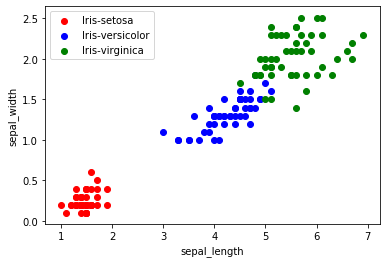

In [15]:
# Extraction des features 
X_iris = iris.iloc[:, :-1].values # Premières colonnes 

Y_iris = iris.iloc[:,-1].values # Dernière colonne 

setosa = iris["class"] == "Iris-setosa"
versicolor = iris["class"] == "Iris-versicolor"
virginica = iris["class"] == "Iris-virginica"

plt.scatter(X_iris[setosa, 0], X_iris[setosa, 1], color="red", label="Iris-setosa")
plt.scatter(X_iris[versicolor, 0], X_iris[versicolor, 1], color="blue", label="Iris-versicolor")
plt.scatter(X_iris[virginica, 0], X_iris[virginica, 1], color="green", label="Iris-virginica")

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend()
plt.show()

In [16]:
# Randomization des données pour marquer les 80% lignes
# Le même masque sera utilisé pour les deux solutions
iris_msk = np.random.rand(len(X_iris)) < 0.8 
X_iris_train = np.array(X_iris[iris_msk, :], dtype=np.float32)
X_iris_test = np.array(X_iris[~iris_msk, :], dtype=np.float32)

In [17]:
iris["class"].value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: class, dtype: int64

In [18]:
# Encodage des classes 
Y_iris_setosa = (Y_iris == "Iris-setosa").astype(int)
Y_iris_versicolor = (Y_iris == "Iris-versicolor").astype(int)
Y_iris_virginica = (Y_iris == "Iris-virginica").astype(int)

Y_iris_setosa.sum(), Y_iris_versicolor.sum(), Y_iris_virginica.sum()

(50, 50, 50)

In [19]:
# encoder setosa par 1
Y_iris_setosa_test = np.array(Y_iris_setosa[~iris_msk], dtype=np.float32)
# encoder versicolor par 2
Y_iris_versicolor_test = np.array(Y_iris_versicolor[~iris_msk], dtype=np.float32) * 2
# encoder la sortie par 3
Y_iris_virginica_test = np.array(Y_iris_virginica[~iris_msk], dtype=np.float32) * 3
# fusionner les trois vecteurs pour avoir un seul avec les classes encodées
Y_iris_test = Y_iris_setosa_test + Y_iris_versicolor_test + Y_iris_virginica_test 
Y_iris_test

array([3., 3., 1., 1., 2., 1., 1., 1., 2., 1., 2., 1., 3., 1., 3., 3., 3.,
       3., 2., 3., 2., 3., 2., 3., 2., 1., 1., 3., 2., 1., 1., 1., 3., 1.,
       2., 2., 2., 1., 3.], dtype=float32)

### 2.1- Entrainer 3 modèles de régression lgistique binaire

Pour ce faire, recopier votre solution du TP précédent

In [20]:
def generer_zeros_1(nbr):
    return np.zeros(nbr)

def generer_uns_1(nbr):
    return np.ones(nbr)

def generer_aleatoire_1(nbr):
    return np.random.rand(nbr)

# TODO recopier z_1(X, Theta) ici
def z_1(X, Theta): 
    return np.dot(X,Theta.T)

# TODO recopier sigmoid(X) ici
def sigmoid(X):
    # Fonction d'activation utilisée pour rendre les valeurs réelles entre 0 et 1 
    return  1 / (1 + np.exp(-X))


def h_1(X, Theta, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return sigmoid(z_1(X_pre, Theta))

# TODO recopier J_1(H, Y) ici
def J_1(H, Y): 
    m=Y.shape[0]
    couts = -Y * np.log(H) - (1 - Y) * np.log(1- H)
    return np.sum(couts) / m



# TODO recopier gradient_1(X, H, Y) ici
def gradient_1(X, H, Y):
    m=Y.shape[0]
    return  (1/m)* X.T.dot(H - Y)



def entrainer_1(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_1, h_func=h_1, J_func=J_1, grad_func=gradient_1): 
    
    X_pre, mean, std = preparer(X, norm, const)
    Theta = theta_func(X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts

# TODO recopier predire_1(H, seuil=0.5) ici
def predire_1(H, seuil=0.5): 
    return (H>=seuil)+0


class RegLogistique(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_1, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        self.Theta, self.mean, self.std, self.couts = entrainer_1(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_1(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_1(H, seuil1=seuil)

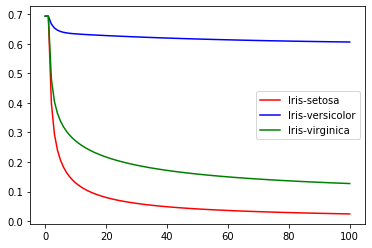

In [21]:
#modèle 1
Y_iris_setosa_train = np.array(Y_iris_setosa[iris_msk], dtype=np.float32)
reg_iris_setosa = RegLogistique()
reg_iris_setosa.entrainer(X_iris_train, Y_iris_setosa_train)

#modèle 2
Y_iris_versicolor_train = np.array(Y_iris_versicolor[iris_msk], dtype=np.float32)
reg_iris_versicolor = RegLogistique()
reg_iris_versicolor.entrainer(X_iris_train, Y_iris_versicolor_train)


#modèle 3
Y_iris_virginica_train = np.array(Y_iris_virginica[iris_msk], dtype=np.float32)
reg_iris_virginica = RegLogistique()
reg_iris_virginica.entrainer(X_iris_train, Y_iris_virginica_train)

#Affichage des évolutions des couts 
plt.plot(reg_iris_setosa.couts, color="red", label="Iris-setosa")
plt.plot(reg_iris_versicolor.couts, color="blue", label="Iris-versicolor")
plt.plot(reg_iris_virginica.couts, color="green", label="Iris-virginica")
plt.legend()
plt.show()

**Question** : Que remarquez-vous concernant la convergence de chaque modèle?

On remarque que le model Iris-setosa converge mieux (cout minimum) suivis de Iris-virginica et enfin Iris-versicolor qui ne donne pas de bon resultat (cout >0.6) , chose logique par rapport au scatter plot précédent ou on remarque que Iris-setosa et le mieux séparer des deux classes Iris-versicolor et Iris-virginica qui sont entremélés, en plus les points représentant Iris-versicolor se trouvent au milieux chose qui rends théoriquement impossible la classification de ce dernier avec une regression logistique binaire seulement (une seule droite) et on a besoin d'appliquer l'algorithme one-vs-all dans ce cas

### 2.2- Entrainer 1 modèle de régression lgistique multinomiale


In [22]:
# Encodage des classes (on peut utiliser OneHotEncoder de scikit-learn)
# Ici, on va l'implémenter en utilisant numpy pour bien comprendre comment l'encodage fonctionne 
Y_iris_onehot_train = np.column_stack((Y_iris_setosa_train, Y_iris_versicolor_train, Y_iris_virginica_train))

Y_iris_onehot_train[:4, :], Y_iris[:4]

(array([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32),
 array(['Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
        'Iris-virginica'], dtype=object))

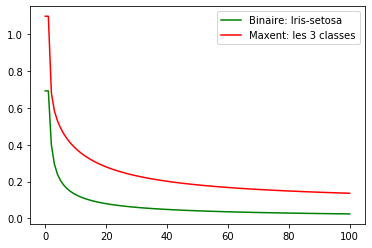

In [23]:
maxent_iris = MaxEnt()
maxent_iris.entrainer(X_iris_train, Y_iris_onehot_train)


#Affichage des évolutions des couts 
plt.plot(reg_iris_setosa.couts, color="green", label="Binaire: Iris-setosa")
plt.plot(maxent_iris.couts, color="red", label="Maxent: les 3 classes")
plt.legend()
plt.show()

**Question** : Que remarquez-vous? Que pouvez-vous dire à propos de la classe "Iris-setosa"?

On remarque qu'on obtient de meuilleure resultat (un cout moindre) pour la classe Iris-setosa en utilisant un modele binaire, d'ou on peut dire que Iris-setosa est bien séparé des autres classes *ie: une seule droite peut séparé Iris-setosa du reste*

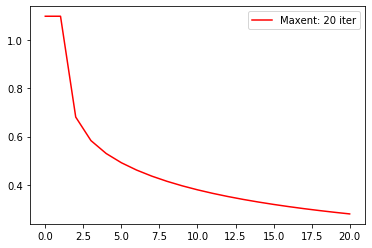

In [24]:
# On entraine un modèle Maxent sans le laisser converger
# nombre des itérations 20
maxent20_iris = MaxEnt(nbr_iter=20)
maxent20_iris.entrainer(X_iris_train, Y_iris_onehot_train)


#Affichage des évolutions des couts 
plt.plot(maxent20_iris.couts, color="red", label="Maxent: 20 iter")
plt.legend()
plt.show()

### 2.3- Tester et comparer les deux solutions 




In [25]:
# Prédiction des probabilités avec les trois modèles binaires
#modèle 1
iris_setosa_prob = reg_iris_setosa.predire(X_iris_test)
#modèle 2
iris_versicolor_prob = reg_iris_versicolor.predire(X_iris_test)
#modèle 3
iris_virginica_prob = reg_iris_virginica.predire(X_iris_test)

# fusionner les probabilités en une matrice
iris_modeles3_prob = np.column_stack((iris_setosa_prob, iris_versicolor_prob, iris_virginica_prob))

# encodage des sorties en 1, 2, 3
iris_modeles3_test = np.argmax(iris_modeles3_prob, axis=1) + 1

iris_modeles3_test

array([3, 3, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 3, 1, 3, 3, 3, 3, 2, 3, 2, 3,
       2, 3, 2, 1, 1, 3, 2, 1, 1, 1, 3, 1, 2, 3, 2, 1, 3], dtype=int64)

In [26]:
# Prédiction des probabilités avec le modèle multinomial
iris_maxent_prob = maxent_iris.predire(X_iris_test)

# encodage des sorties en 1, 2, 3
iris_maxent_test = np.argmax(iris_maxent_prob, axis=1) + 1

iris_maxent_test

array([3, 3, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 3, 3, 3, 2, 3, 2, 3,
       2, 2, 2, 1, 1, 3, 2, 1, 1, 1, 3, 1, 2, 2, 2, 1, 3], dtype=int64)

In [27]:
# Prédiction des probabilités avec le modèle multinomial avec 5 itérations
iris_maxent20_prob = maxent20_iris.predire(X_iris_test)

# encodage des sorties en 1, 2, 3
iris_maxent20_test = np.argmax(iris_maxent20_prob, axis=1) + 1

iris_maxent20_test

array([3, 3, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 3, 3, 3, 2, 3, 2, 3,
       2, 3, 2, 1, 1, 3, 2, 1, 1, 1, 3, 1, 2, 2, 2, 1, 3], dtype=int64)

In [28]:
from sklearn.metrics import classification_report
noms_classes = ["setosa", "versicolor", "virginica"]

# Par 3 modèles
print("En utilisant 3 modèles de régression binaire")
print(classification_report(Y_iris_test, iris_modeles3_test, target_names=noms_classes))

# Par 1 modèle multinomial
print("En utilisant 1 modèle de régression multinomiale")
print(classification_report(Y_iris_test, iris_maxent_test, target_names=noms_classes))

# Par 1 modèle multinomial (20 itérations)
print("En utilisant 1 modèle de régression multinomiale (20 itérations)")
print(classification_report(Y_iris_test, iris_maxent20_test, target_names=noms_classes))

# Ignorer le Warning en bas

En utilisant 3 modèles de régression binaire
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.82      0.90        11
   virginica       0.87      1.00      0.93        13

    accuracy                           0.95        39
   macro avg       0.96      0.94      0.94        39
weighted avg       0.96      0.95      0.95        39

En utilisant 1 modèle de régression multinomiale
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.92      1.00      0.96        11
   virginica       1.00      0.92      0.96        13

    accuracy                           0.97        39
   macro avg       0.97      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39

En utilisant 1 modèle de régression multinomiale (20 itérations)
              precision    recall  f1-score   support

      setosa       1.00 

**Question** : Anlysez les résulats
>On remarque que la regression multinomiale est en générale meilleure que la regression binaire avec nos 3 classes et le resultat devient même parfait apres 20 itérations pour la regression multinomiale ***precision=recall=f1score=accuracy=100%***